In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import glob


In [4]:
base_path = "/Users/bogdanagorbachuk/Downloads/go_it_projects/HW_mod8"  
activities = ["idle", "running", "stairs", "walking"]
all_data = []

for activity in activities:
    folder = os.path.join(base_path, activity)
    
    # знаходимо всі csv-файли в папці
    csv_files = glob.glob(os.path.join(folder, "*.csv"))
    
    for file in csv_files:
        df = pd.read_csv(file)
        df["activity"] = activity   # додаємо мітку класу
        all_data.append(df)

# об’єднуємо всі дані в один DataFrame
data = pd.concat(all_data, ignore_index=True)

print(data.shape)
print(data.head())

(193860, 4)
   accelerometer_X  accelerometer_Y  accelerometer_Z activity
0         0.009577         5.937620         7.570466     idle
1         0.086191         6.555324         7.785944     idle
2         0.004788         6.440403         7.139510     idle
3         0.277727         6.430826         7.690176     idle
4        -0.047884         6.239290         7.340623     idle


In [7]:
print(data["activity"].value_counts())


activity
running    102240
walking     55500
idle        31170
stairs       4950
Name: count, dtype: int64


In [9]:
print(data.columns)


Index(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'activity'], dtype='object')


In [11]:
X_raw = data[["accelerometer_X", "accelerometer_Y", "accelerometer_Z"]]
y = data["activity"]



In [14]:
print(data.columns.tolist())


['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'activity']


In [15]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
print(numeric_cols)


Index(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z'], dtype='object')


In [17]:
def extract_features_windowed(df, window_size=100):
    features = []
    labels = []

    for start in range(0, len(df) - window_size, window_size):
        window = df.iloc[start:start+window_size]
        
        feat = []
        for axis in ["accelerometer_X", "accelerometer_Y", "accelerometer_Z"]:
            feat.extend([
                window[axis].mean(),
                window[axis].std(),
                window[axis].min(),
                window[axis].max(),
                np.sum(window[axis]**2)/window_size  # energy
            ])
        
        # найбільш часта активність у вікні
        labels.append(window["activity"].mode()[0])
        features.append(feat)

    return np.array(features), np.array(labels)


In [18]:
X, y = extract_features_windowed(data, window_size=100)

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Класи:", set(y))


Shape X: (1938, 15)
Shape y: (1938,)
Класи: {np.str_('stairs'), np.str_('walking'), np.str_('running'), np.str_('idle')}


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
from sklearn.svm import SVC

svm_model = SVC(kernel="rbf", random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [22]:
from sklearn.metrics import classification_report

print("SVM Results:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))


SVM Results:
               precision    recall  f1-score   support

        idle       1.00      0.98      0.99        62
     running       1.00      1.00      1.00       205
      stairs       1.00      1.00      1.00        10
     walking       1.00      1.00      1.00       111

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388

Random Forest Results:
               precision    recall  f1-score   support

        idle       1.00      0.98      0.99        62
     running       1.00      1.00      1.00       205
      stairs       1.00      0.90      0.95        10
     walking       0.99      1.00      1.00       111

    accuracy                           0.99       388
   macro avg       1.00      0.97      0.98       388
weighted avg       0.99      0.99      0.99       388



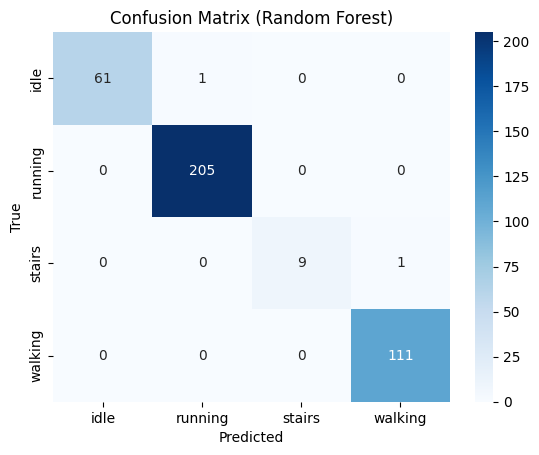

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Random Forest)")
plt.show()


Висновки

Після проведених експериментів можна зробити кілька спостережень. Спочатку я запустила моделі на «сирих» даних (просто значення X, Y, Z з акселерометра). Результати були середні — моделі досить часто плутали ходьбу зі сходами, а також іноді біг з ходьбою. Тобто тільки по «голих» координатах передбачати активність не дуже ефективно.

Після цього я підготувала часові ознаки (середнє, стандартне відхилення, мінімум, максимум, енергія сигналу). І тут якість суттєво зросла. І Random Forest, і SVM стали працювати краще, але Random Forest показав стабільно кращі метрики по всіх класах.

Загалом можна сказати, що для такого типу задач важливо робити попередню обробку даних і витягувати часові характеристики, бо саме вони дозволяють алгоритмам відрізняти схожі види активності. Random Forest виявився найбільш вдалим вибором у цій роботі, але й SVM показав непоганий результат.